In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import numpy as np
from math import radians, cos, sin, asin, sqrt
from copy import deepcopy 
from scipy.stats import norm, kurtosis
import random

In [111]:
df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
df['Random Demand'] = [400*np.random.rand() for x in df.index]
dists = np.load('dists.npy')
data = [df,dists]

def Fair(distribution, agegroups):
    #adapted the fairness formula to take into account that kids/adults/seniors
    #get different amounts of food by design
    allocations = {0:70, 1:56, 2:42} #0 is kids, 1 is adults, 2 is seniors. 
    if len(distribution) == 0:
        return 0
    
    totalsupply = sum(distribution)
    
    fairscore = 0
    for i in range(len(distribution)):
        recieved = distribution[i]/totalsupply
        allocated = allocations[agegroups[i]]/totalsupply
        fairscore += (recieved-allocated)**2
    
    fairscore = 1/(len(distribution)*fairscore+1)

    return fairscore

def returndata(data):
    df = data[0]
    dists = data[1]
    
    stdevs = np.array((df['StDev(Demand per Visit)']))
    variance = stdevs**2
    stdevs = np.sqrt(np.matmul(variance,dists))
    demands = np.array((df['Average Demand per Visit']))
    #demands = np.array((df['Random Demand']))
    increment = np.matmul(demands/(70/772*365), dists) 
    
    return demands, stdevs, increment

def runsite(site, data, RANDOM_DEMAND = True, SECOND_VISIT = False, FOOD = 0, LAST_VISIT = False):
    demands, stdevs, na = returndata(data) #gives the data we need    
    expdemand = demands[site] #expected demand for this site
    stdev = stdevs[site]      #standard deviation of demand at this site
    
    if RANDOM_DEMAND:
        demand = int(random.normalvariate(expdemand,stdev))#normally distributed random variable   
    else:
        demand = int(expdemand)
    
    daysoffood = 14 #how many days we expect the food to last everyone
    ages = np.array([.41,.4,.19]) #proportions of kids/adults/seniors
    fooddist = np.array([5,4,3]) #how many lbs of food kids/ad/sen eat each day
    evfood = np.dot(ages,fooddist*daysoffood) #expected value of food demanded by random person
    
    if SECOND_VISIT:
        LAST_VISIT = True
        totalfood = FOOD
    else:
        totalfood = min(15000,(expdemand+1.645*stdev)*evfood)
    #bring enough food so that you have >50 pounds per person 95% of the time
    
    ppl_food_quantity = []      # initialize array of X_i's for ppl's quanitity in lbs for 2 weeks
    agegroups = [] #age breakdown of crowd

    for i in range(0,demand):  # for each person at a site
        expleft = max(int(expdemand*(1-(i/demand))),1) #expected remaining people
        foodleft = totalfood-sum(ppl_food_quantity) #remaining food
        expfoodperperson = foodleft/expleft #expected remaining food/person
        
        ratio = 1 #default is don't change anything
        if LAST_VISIT: #if its the last visit of the day
            if expfoodperperson > evfood+10: #if we have a lot more food than we expect
                ratio = expfoodperperson/evfood #ratio>1                
        if expfoodperperson < evfood-10: #if we have a lot less food than we expect
            ratio = expfoodperperson/evfood #ratio < 1
        
        x = random.random()#random number to decide age of person
        if x<=ages[0]: #record their age group
                agegroups.append(0)
        elif x<=ages[0]+ages[1]:
            agegroups.append(1)
        else:
            agegroups.append(2)

        if sum(ppl_food_quantity)>totalfood: #if were out of food
            ppl_food_quantity.append(0) #you dont get any
        else:
            if x<=ages[0]:     # the person is a child
                ppl_food_quantity.append(min(100,max(35,fooddist[0]*daysoffood*ratio)))         # 5 lbs of food per day
                agegroups.append(0)
            elif x <= ages[0]+ages[1]:       # the person is an adult
                ppl_food_quantity.append(min(125,max(28,fooddist[1]*daysoffood*ratio)))         # 4lbs of food a day
                agegroups.append(1)
            else:                    # the person is a senior
                ppl_food_quantity.append(min(80,max(21,fooddist[2]*daysoffood*ratio)))       # 3lbs of food a day
                agegroups.append(2)
    # quantitative meansurement of fairness
    fairness_val = Fair(ppl_food_quantity, agegroups)

    if 0 not in ppl_food_quantity: #
        max_ppl_srvd = demand
    else:
        max_ppl_srvd = ppl_food_quantity.index(0)
        
    return fairness_val, max_ppl_srvd, sum(ppl_food_quantity)

In [96]:
#USE THIS CELL TO GENERATE THE SCHEDULES AND VALUES FOR THE PARETO FRONT
data = [df,dists]
demands,stdevs,increment = returndata(data)

schedules = [] 
demandDist = []
fairnesslevels = []

nvisits = np.zeros(70)

factorincrements = 50
maxfactor = 5
inc = maxfactor/factorincrements
factor = 0

while factor <= maxfactor:
    print(factor)
    schedule = [] #empty list for schedule
    demands = np.array((df['Average Demand per Visit']))
    daysElapsed = np.zeros(70)
    excessdemand = 0
    nsrvd = 0
    fairness = 0
    
    for day in range(365):
        
        fx = daysElapsed*factor
        demands = demands + fx

        a = deepcopy(demands)
        a = np.sort(a)

        first = a[-1]
        index1 = np.where(demands == first)
        second = a[-2]
        index2 = np.where(demands == second)

        demands = demands - fx
        
        fair1, maxsrvd1, pds1 = runsite(index1, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        fair2, maxsrvd2, pds2 = runsite(index2, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        
        fairness += fair1*maxsrvd1 + fair2*maxsrvd2
        nsrvd += maxsrvd1 + maxsrvd2
        
        demands = (demands - min(254,pds1/59.08)*dists[index1])[0]
        demands = (demands - min(254,pds1/59.08)*dists[index2])[0]
        
        daysElapsed = daysElapsed+1
        daysElapsed[int(index1[0])] = 0
        daysElapsed[int(index2[0])] = 0

        schedule.append([int(index1[0]),int(index2[0])])
        nvisits[index1] += 1
        nvisits[index2] += 1

        demands = [0 if x<0 else x for x in demands]
        demands = demands + increment
        excessdemand += sum(demands)

    schedules.append(schedule)
    fairnesslevels.append(float(fairness/nsrvd))
    demandDist.append(excessdemand/365)
    
    factor += inc

print(demandDist)
print(fairnesslevels)

0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004
2.1000000000000005
2.2000000000000006
2.3000000000000007
2.400000000000001
2.500000000000001
2.600000000000001
2.700000000000001
2.800000000000001
2.9000000000000012
3.0000000000000013
3.1000000000000014
3.2000000000000015
3.3000000000000016
3.4000000000000017
3.5000000000000018
3.600000000000002
3.700000000000002
3.800000000000002
3.900000000000002
4.000000000000002
4.100000000000001
4.200000000000001
4.300000000000001
4.4
4.5
4.6
4.699999999999999
4.799999999999999
4.899999999999999
4.999999999999998
[5420.980763128149, 5344.919487043757, 5216.841630995801, 5119.271575093682, 5183.764975246681, 5181.426906464779, 5076.352414765018, 4950.988892591389, 5076.170433378914, 5108.062003635046, 5257.21364862681, 5161.176520580904, 5

In [97]:
freqList = []
for level in schedules:
    freq = [0] * 70
    for day in level:
        freq[day[0]] += 1
        freq[day[1]] += 1
    freqList.append(freq)

In [98]:
def gini(list):
    ## first sort
    arr = np.array(list)
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by our 'j' point
            if all(scores[j] < scores[i]) and any(scores[j] <= scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def lorenz_curve(freq):
    X = np.array(freq)
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

<IPython.core.display.Javascript object>


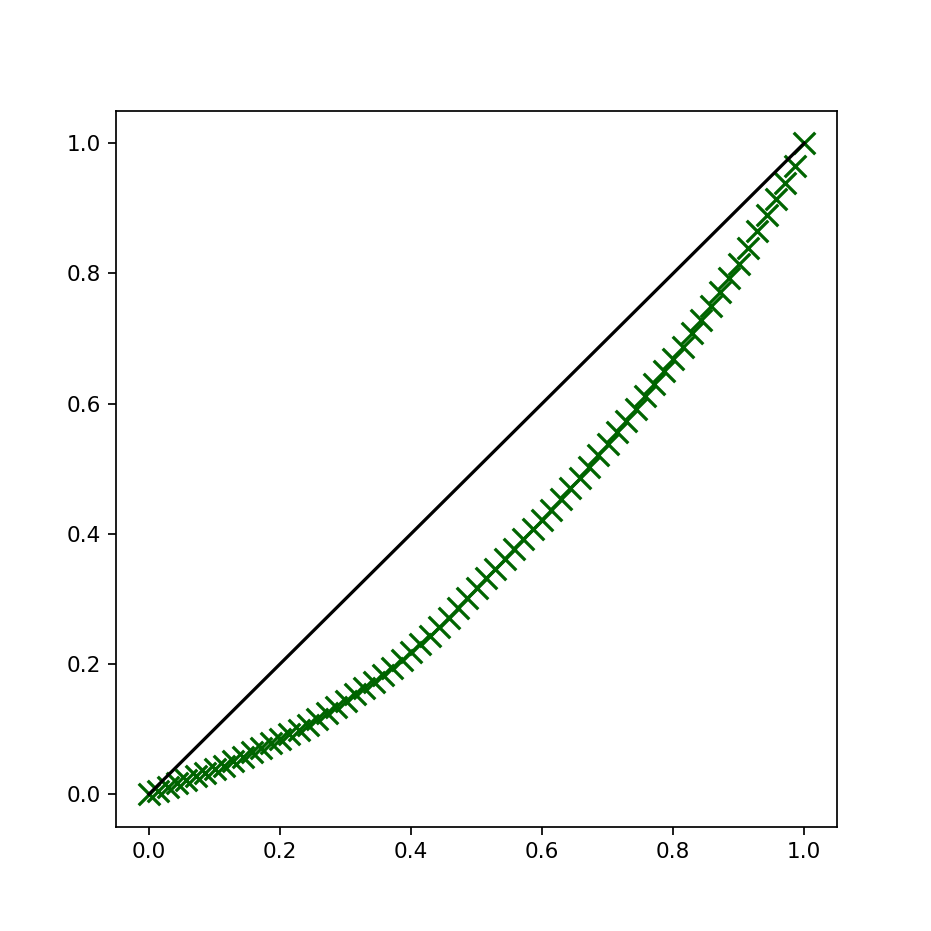

In [110]:
freqList[ideal].sort()
lorenz_curve(freqList[ideal])

In [101]:
unfairness = [1 - i for i in fairnesslevels] #minimize unfairness = maximize fairness
giniList = []
for i in freqList:
    giniList.append(gini(i))
minimize = np.column_stack((demandDist, giniList, unfairness))

<IPython.core.display.Javascript object>


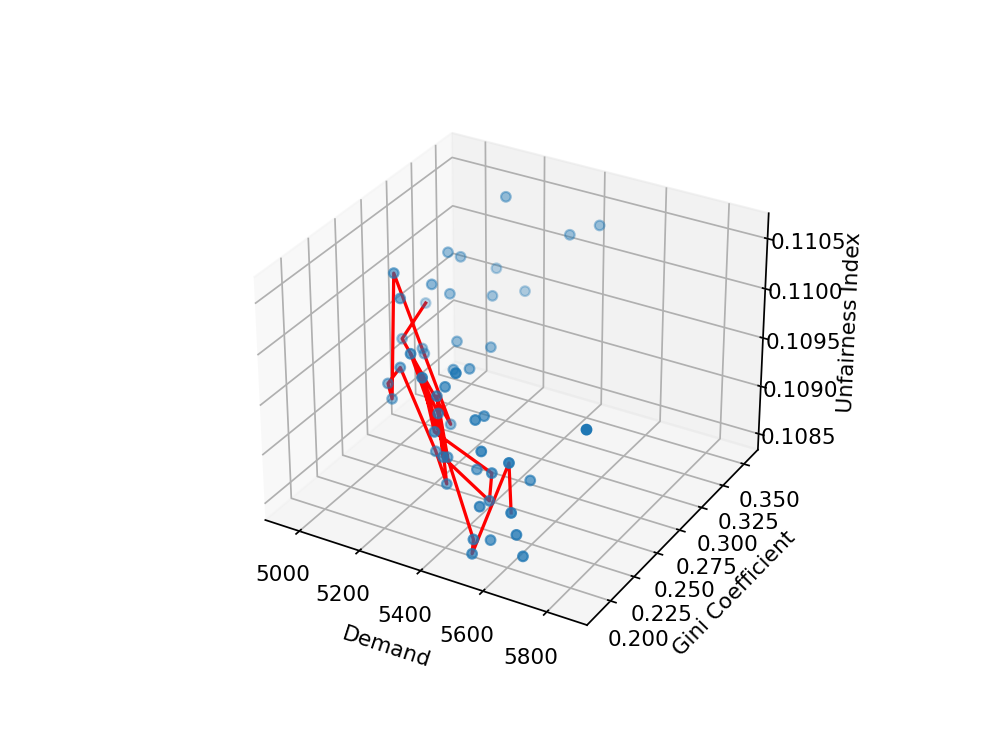

In [102]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
pareto = identify_pareto(minimize)
pareto_front = minimize[pareto]
x_all = minimize[:, 0]
y_all = minimize[:, 1]
z_all = minimize[:, 2]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]
z_pareto = pareto_front[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_all, y_all, z_all)
ax.plot(x_pareto, y_pareto, z_pareto, color='r')
ax.set_xlabel('Demand')
ax.set_ylabel('Gini Coefficient')
ax.set_zlabel('Unfairness Index')
plt.show()

In [103]:
#RUN THIS CELL TO GENERATE THE BEST SCHEDULE
unfairness = 1 - np.array(fairnesslevels)

scaleddemand = (demandDist-min(demandDist))/(max(demandDist)-min(demandDist))
scaledfairness = (max(unfairness) - unfairness)/(max(unfairness)-min(unfairness))
scaledgini = (giniList-min(giniList))/(max(giniList)-min(giniList))

weightedarray = .5*scaleddemand+.3*scaledfairness+.2*scaledgini
ideal = np.where(weightedarray == min(weightedarray))[0][0]
idealfactor = ideal*inc

bestschedule = schedules[ideal]
#print(bestschedule) #our proposed 365 day schedule
totaldemand = demandDist[ideal]
ourfairness = fairnesslevels[ideal]
ginicoeff = giniList[ideal]

print(totaldemand,ourfairness,ginicoeff)

5061.518774696657 0.8896776490774467 0.2542074363992173


In [105]:
def testschedule(schedule):
    ntrials = 10
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    for i in range(ntrials):
        demands, stdevs, increment = returndata(data)
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0]
            site2 = day[1]
            
            fair1, nsrvd1, lbs1 = runsite(site1, data, LAST_VISIT = True)
            fair2, nsrvd2, lbs2 = runsite(site2, data, LAST_VISIT = True)            
            
            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
        
            demands = [0 if x<0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Gini Coefficient: ', Gini_Coefficient)
    print('Total Food Distributed: ', Total_Food)
    
    return [Average_Demand, Average_Fairness, Gini_Coefficient, Total_Food]

def testschedule2(schedule):
    ntrials = 10
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    for i in range(ntrials):
        demands, stdevs, increment = returndata(data)
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0][0]
            site12 = day[0][1]
            site2 = day[1][0]
            site22 = day[1][1]
            
            fair1, nsrvd1, lbs1 = runsite(site1, data, LAST_VISIT = False)
            fair2, nsrvd2, lbs2 = runsite(site2, data, LAST_VISIT = False)            
            
            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            demands = [0 if x < 0 else x for x in demands]
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
            
            if site12 != -1:
                fair12, nsrvd12, lbs12 = runsite(site12, data, LAST_VISIT = True)
                fairness += fair12*nsrvd12
                nsrvd += nsrvd12
                demands = (demands - min(254 - nsrvd1, lbs12/59.08)*dists[site12])
                nvisits[site12] += 1
                totallbs += lbs12
                demands = [0 if x < 0 else x for x in demands]
            
            if site22 != -1:
                fair22, nsrvd22, lbs22 = runsite(site22, data, LAST_VISIT = True)
                fairness += fair22*nsrvd22
                nsrvd += nsrvd22
                demands = (demands - min(254 - nsrvd2, lbs22/59.08)*dists[site22])
                nvisits[site22] += 1
                totallbs += lbs22
                demands = [0 if x < 0 else x for x in demands]
                 
        
            
            
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Gini Coefficient: ', Gini_Coefficient)
    print('Total Food Distributed: ', Total_Food)
    
    return [Average_Demand, Average_Fairness, Gini_Coefficient, Total_Food]

In [106]:
def locate_min(a):
    smallest = min(a) #returns indices of all elements in list equal to the minimum element
    return [index for index, element in enumerate(a) if smallest == element]  
def locate_max(a):
    biggest = max(a)
    return [index for index, element in enumerate(a) if biggest == element]

In [107]:
countList = []
for year in schedules:
    freq = [0] * 70
    for day in year:
        freq[day[0]] += 1
        freq[day[1]] += 1
    countList.append(freq)
    
nSchedule = []
na, stdevs, na = returndata([df,dists])
avgDemands = df['Average Demand per Visit']

for day in schedules[ideal]: #run the best schedule block to get ideal
    daily = []
    for site in day:
        totalfood = min(15000, (avgDemands[site] + 1.645*stdevs[site])*59.08)
        leftover = (totalfood - (avgDemands[site]*59.08))

        if leftover >= (min(avgDemands)+1.645*stdevs[list(avgDemands).index(min(avgDemands))])*59.08: #95% threshold
            rare = locate_min(countList[ideal])
            rare_demand = []
            
            for i in rare:
                rare_demand.append(avgDemands[i])
            second = locate_max(rare_demand)
            visit = avgDemands[avgDemands == rare_demand[second[0]]]

            index = int(visit.index.tolist()[0])
            daily.append([site, index])
            countList[ideal][index] += 1
        
        else:
            daily.append([site, -1])
    nSchedule.append(daily)
nSchedule

[[[65, -1], [1, -1]],
 [[16, -1], [2, -1]],
 [[27, -1], [31, -1]],
 [[61, -1], [12, -1]],
 [[10, -1], [29, -1]],
 [[21, -1], [30, -1]],
 [[5, -1], [28, -1]],
 [[65, -1], [4, -1]],
 [[0, 35], [64, -1]],
 [[67, 55], [68, 38]],
 [[63, 48], [33, 45]],
 [[1, -1], [9, 54]],
 [[20, -1], [25, 59]],
 [[69, 60], [17, 43]],
 [[3, 50], [7, 58]],
 [[8, 40], [32, 47]],
 [[13, -1], [18, -1]],
 [[22, 37], [14, 35]],
 [[16, -1], [23, 44]],
 [[2, -1], [34, -1]],
 [[11, 55], [31, -1]],
 [[27, -1], [66, -1]],
 [[12, -1], [19, 49]],
 [[65, -1], [61, -1]],
 [[62, 38], [10, -1]],
 [[15, 48], [30, -1]],
 [[26, 45], [39, -1]],
 [[21, -1], [24, -1]],
 [[29, -1], [6, 54]],
 [[1, -1], [28, -1]],
 [[64, -1], [5, -1]],
 [[4, -1], [68, 59]],
 [[67, 60], [9, 52]],
 [[0, 53], [63, 43]],
 [[42, -1], [41, 50]],
 [[56, -1], [20, -1]],
 [[36, -1], [57, -1]],
 [[25, 58], [31, -1]],
 [[33, 40], [65, -1]],
 [[16, -1], [8, 47]],
 [[3, 37], [7, 35]],
 [[2, -1], [69, 44]],
 [[13, -1], [52, -1]],
 [[27, -1], [17, 55]],
 [[66, -1

In [15]:
foodMap = fm.Map(location=[42.3, -76.5], tiles='Stamen Toner', zoom_start = 9.2)
coordinates = df[['latitude', 'longitude']]
coordinateList = coordinates.values.tolist()
#print(coordinateList)
for element in coordinateList:
    fm.CircleMarker(element, radius=3, color='blue', opacity=0.3).add_to(foodMap)
foodMap

In [78]:
final = []
for i in nSchedule:
    daily = []
    for j in i:
        truck = []
        for k in j:
            if k == -1:
                truck.append('None')
            else:
                truck.append(df.at[k,'Site Name'])
        daily.append(truck)
    final.append(daily)